# EIP-7904 estimated times and gas analysis

#### Maria Silva, September 2025

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
# plotting theme
sns.set_theme(
    style="whitegrid", palette="Set2", rc={"figure.dpi": 500, "axes.titlesize": 15}
)

## Load and process data

This data was taken directly from the [EIP's additional files](https://github.com/ethereum/EIPs/blob/master/assets/eip-7904/final_gas_schedule_comparison.csv).

In [4]:
# Main directories
current_path = os.getcwd()
repo_dir = os.path.abspath(os.path.join(current_path, ".."))
data_dir = os.path.join(repo_dir, "data")

In [5]:
df = pd.read_csv(os.path.join(data_dir, "final_gas_schedule_comparison.csv"))
df = df.drop(columns=["ethereumjs_gas", "ethereumjs_gas_stderr", "evmone_gas", "evmone_gas_stderr"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   besu_gas                    167 non-null    float64
 1   besu_gas_stderr             167 non-null    float64
 2   erigon_gas                  166 non-null    float64
 3   erigon_gas_stderr           166 non-null    float64
 4   geth_gas                    166 non-null    float64
 5   geth_gas_stderr             166 non-null    float64
 6   nethermind_gas              166 non-null    float64
 7   nethermind_gas_stderr       166 non-null    float64
 8   revm_gas                    154 non-null    float64
 9   revm_gas_stderr             154 non-null    float64
 10  opcode                      167 non-null    object 
 11  constant_current_gas        167 non-null    float64
 12  alternative_gas             167 non-null    float64
 13  alternative_gas_stderr      167 non

In [6]:
client_gas_cols = [c for c in df.columns[:9] if c.endswith("_gas")]
client_std_cols = [c for c in df.columns[:9] if c.endswith("_stderr")]

param_df = df.melt(
    id_vars=["opcode"],
    value_vars=[c for c in df.columns[:9] if c.endswith("_gas")],
    var_name="client",
    value_name="param_ns",
)
param_df["client"] = param_df["client"].str.replace("_gas", "")

param_std_df = df.melt(
    id_vars=["opcode"],
    value_vars=[c for c in df.columns[:9] if c.endswith("_stderr")],
    var_name="client",
    value_name="param_ns_std",
)
param_std_df["client"] = param_std_df["client"].str.replace("_gas_stderr", "")

param_df = pd.merge(
    param_df, param_std_df, on=["opcode", "client"], how="outer"
)
param_df

,opcode,client,param_ns,param_ns_std
0,ADD,besu,7.171282,0.329354
1,ADD,erigon,2.224481,0.376086
2,ADD,geth,-20.365305,1.585988
3,ADD,nethermind,4.661051,0.350400
4,ADD,revm,1.922113,NaN
...,...,...,...,...
830,XOR,besu,3.953536,0.392942
831,XOR,erigon,2.561204,0.247232
832,XOR,geth,2.760122,0.090700
833,XOR,nethermind,1.000364,0.351100


In [7]:
param_df[param_df["opcode"]=="ECRECOVER"]

,opcode,client,param_ns,param_ns_std
215,ECRECOVER,besu,5982.443712,9.560379
216,ECRECOVER,erigon,17191.023993,7.580070
217,ECRECOVER,geth,15141.915062,34.274437
218,ECRECOVER,nethermind,1966.301767,30.474679
219,ECRECOVER,revm,NaN,NaN


## Near zeros

In [8]:
param_df[param_df["param_ns"].round(1)==0.0].groupby("opcode").size().sort_values(ascending=False)

opcode
RETURNDATACOPY_ARG2    5
RETURN_ARG1            5
REVERT_ARG1            5
LOG0_ARG1              2
LOG1_ARG1              2
LOG2_ARG1              2
LOG3_ARG1              2
LOG4_ARG1              2
SHA2-256_ARG1          2
RIPEMD-160_ARG1        1
TLOAD_EXT              1
STATICCALL             1
CALL                   1
REVERT                 1
DELEGATECALL           1
RETURN                 1
TSTORE_EXT             1
dtype: int64

RETURNDATACOPY_ARG2, RETURN_ARG1 and REVERT_ARG1 have a lot of near zero values. We will exclude them from the analysis.

In [9]:
param_df = param_df[~param_df["opcode"].isin(["REVERT_ARG1", "RETURN_ARG1", "RETURNDATACOPY_ARG2"])]

## Worse vs. second worse

In [9]:
diff_df = (
    param_df.sort_values("param_ns")
    .groupby(["opcode"])
    .tail(2)  # get worst and second worst
    .sort_values(["opcode", "param_ns"])
    .groupby(["opcode"])["param_ns"]
    .apply(
        lambda x: pd.Series(
            {
                "second_worst_minus_worst": x.iloc[1] - x.iloc[0],
                "worst_param_ns": x.iloc[0],
            }
        )
    )
    .reset_index()
    .pivot_table(
        index=["opcode"],
        columns="level_1",
        values="param_ns",
    )
    .reset_index()
)
diff_df["second_worst_minus_worst_pct"] = (
    diff_df["second_worst_minus_worst"] / diff_df["worst_param_ns"]
)
diff_df.describe()


level_1,second_worst_minus_worst,worst_param_ns,second_worst_minus_worst_pct
count,151.000000,1.630000e+02,151.000000
mean,13.003118,2.546659e+04,0.510034
std,116.149942,1.843510e+05,0.647839
min,0.005915,9.948368e-02,0.003023
25%,0.236571,2.314377e+00,0.081389
50%,1.077785,3.946374e+00,0.201463
75%,4.681762,9.973212e+00,0.824019
max,1425.632891,1.967311e+06,3.335352


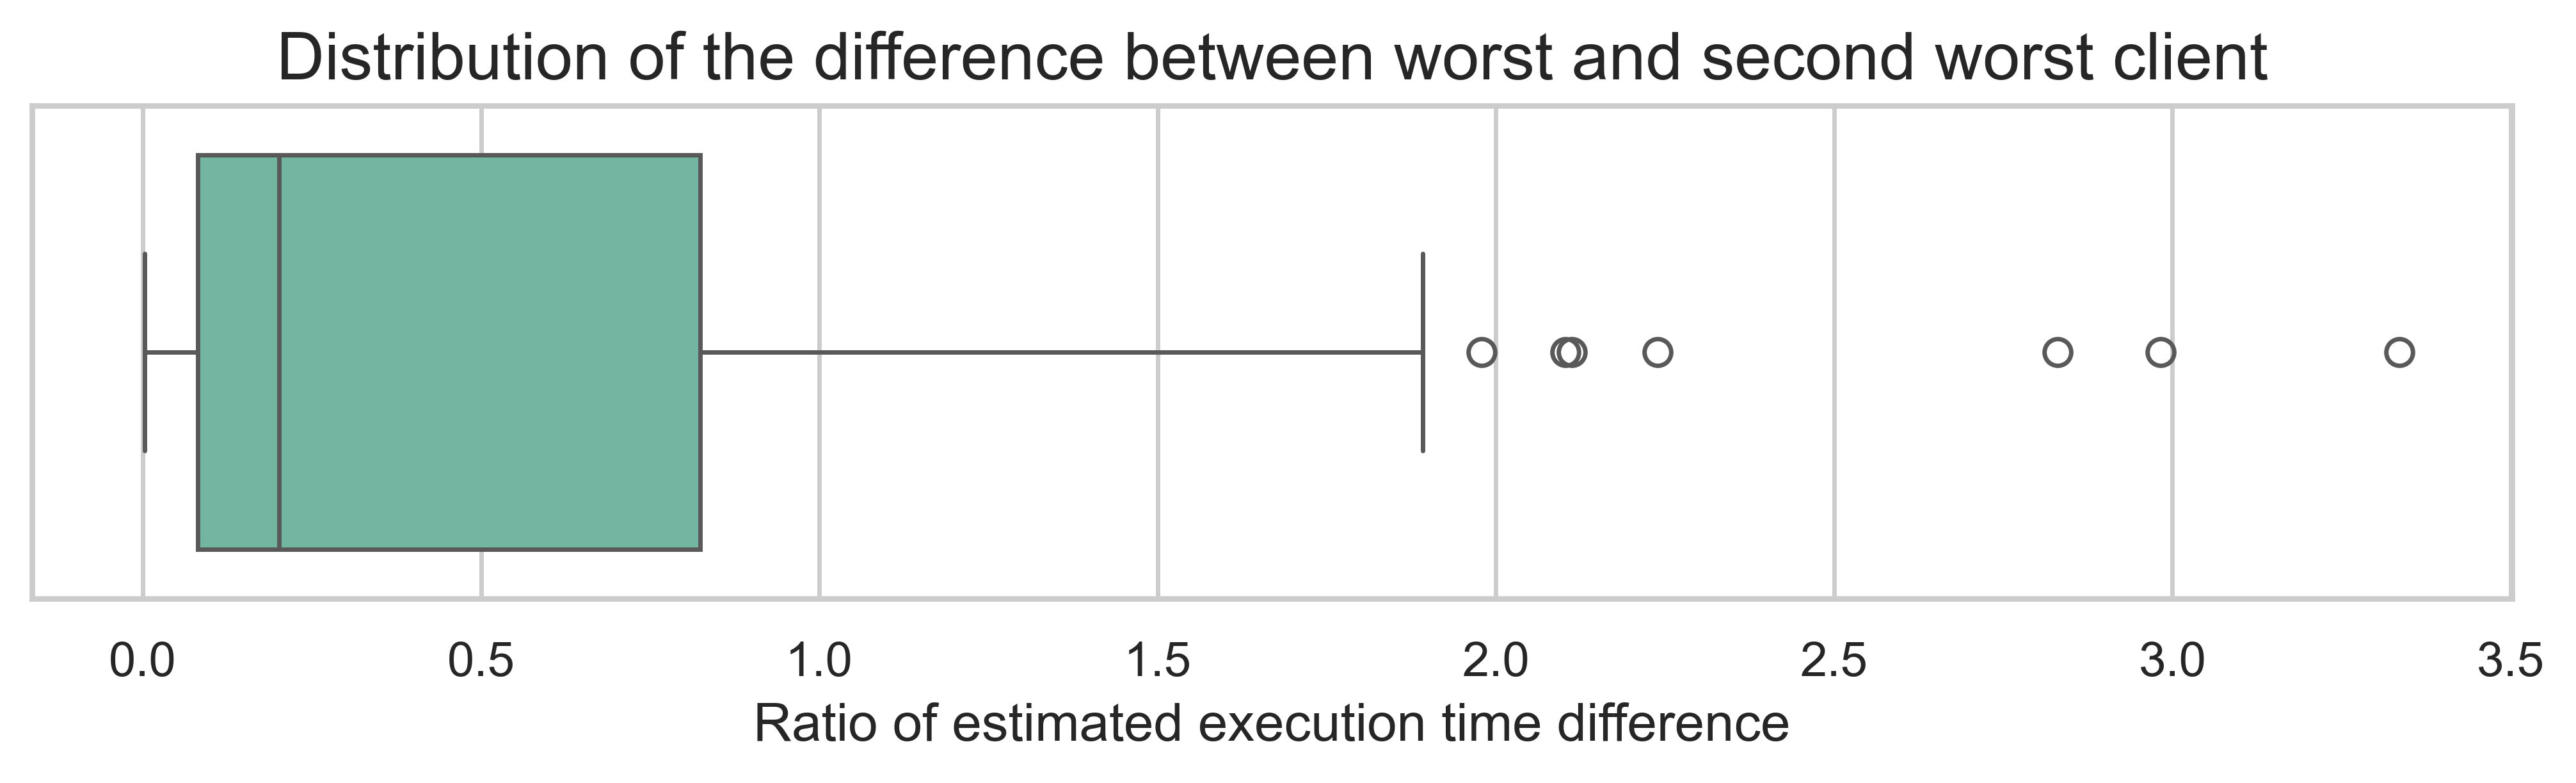

In [10]:
plt.figure(figsize=(10, 2))
sns.boxplot(
    data=diff_df,
    x="second_worst_minus_worst_pct"
)
plt.title("Distribution of the difference between worst and second worst client")
plt.ylabel("")
plt.xlabel("Ratio of estimated execution time difference")
plt.show()

In [11]:
diff_df[diff_df["second_worst_minus_worst_pct"] > 1].sort_values(
    "second_worst_minus_worst_pct", ascending=False
)

level_1,opcode,second_worst_minus_worst,worst_param_ns,second_worst_minus_worst_pct
71,MCOPY_ARG2,0.464044,0.139129,3.335352
132,SHA2-256_ARG1,0.572552,0.191963,2.982614
82,NOT,5.603328,1.979485,2.830700
114,PUSH32,9.510279,4.247256,2.239159
110,PUSH29,8.671623,4.105093,2.112406
112,PUSH30,8.737367,4.155480,2.102613
108,PUSH27,7.771035,3.926219,1.979267
74,MOD,10.692398,5.652557,1.891604
109,PUSH28,7.612297,4.066943,1.871749
113,PUSH31,8.453242,4.640911,1.821462


In [12]:
diff_df[diff_df["second_worst_minus_worst"] > 50].sort_values(
    "second_worst_minus_worst", ascending=False
)

level_1,opcode,second_worst_minus_worst,worst_param_ns,second_worst_minus_worst_pct
16,CREATE,1425.632891,1511.568117,0.943148
58,KECCAK256,116.315086,160.948713,0.722684


In [13]:
param_df[param_df["opcode"].isin(["CREATE", "KECCAK256"])]

,opcode,client,param_ns,param_ns_std
80,CREATE,besu,805.474028,12.985422
81,CREATE,erigon,1511.568117,8.060453
82,CREATE,geth,2937.201008,10.446054
83,CREATE,nethermind,621.921224,4.375626
84,CREATE,revm,5.005418,NaN
295,KECCAK256,besu,68.101207,0.495919
296,KECCAK256,erigon,137.303782,1.322054
297,KECCAK256,geth,160.948713,1.054055
298,KECCAK256,nethermind,47.266539,0.562530
299,KECCAK256,revm,277.263800,NaN


## Setting gas costs by worse client - ecRecover anchor

In [14]:
param_df[param_df["opcode"]=="ECRECOVER"]

,opcode,client,param_ns,param_ns_std
215,ECRECOVER,besu,5982.443712,9.560379
216,ECRECOVER,erigon,17191.023993,7.580070
217,ECRECOVER,geth,15141.915062,34.274437
218,ECRECOVER,nethermind,1966.301767,30.474679
219,ECRECOVER,revm,NaN,NaN


Translating the execution time of ecRecover for the worse client to Mgas/s we get:

In [15]:
ecrecover_param = param_df[param_df["opcode"]=="ECRECOVER"]["param_ns"].max()
ecrecover_param
print("EcRecover execution time:", round(ecrecover_param), "ns")
print("EcRecover derived Mgas/s:", round((1e9*3000/ecrecover_param)/1e6))

EcRecover execution time: 17191 ns
EcRecover derived Mgas/s: 175


In [16]:
new_gas_df = (
    param_df.drop(columns="param_ns_std")
    .dropna()
    .sort_values("param_ns")
    .groupby("opcode")
    .last()
    .reset_index()
)
# EcRecover anchor
a = 3000 / ecrecover_param
print("ecRecover Anchor Multiplier:", round(a, 2))
new_gas_df["new_gas"] = new_gas_df["param_ns"] * a
new_gas_df["new_gas_rounded"] = new_gas_df["new_gas"].round().astype(int)
new_gas_df["new_gas_rounded"] = np.where(
    new_gas_df["new_gas_rounded"] == 0, 1, new_gas_df["new_gas_rounded"]
)
new_gas_df = new_gas_df.merge(
    df[["opcode", "constant_current_gas", "alternative_gas"]], on="opcode", how="left"
)
new_gas_df["new_gas_change"] = (
    new_gas_df["new_gas_rounded"] - new_gas_df["constant_current_gas"]
) / new_gas_df["constant_current_gas"]

new_gas_df.to_csv(os.path.join(data_dir, "proposed_gas_schedule_175mgs.csv"), index=False)

ecRecover Anchor Multiplier: 0.17


In [17]:
new_gas_df

,opcode,client,param_ns,new_gas,new_gas_rounded,constant_current_gas,alternative_gas,new_gas_change
0,ADD,besu,7.171282,1.251458,1,3.0,2.224481,-0.666667
1,ADDMOD,revm,25.502540,4.450440,4,8.0,8.116796,-0.500000
2,ADDRESS,geth,7.997121,1.395575,1,2.0,5.274908,-0.500000
3,AND,besu,3.857343,0.673144,1,3.0,2.461954,-0.666667
4,BLAKE2F,besu,258.113508,45.043304,45,112.0,172.546564,-0.598214
...,...,...,...,...,...,...,...,...
159,TLOAD_EXT,geth,28.841101,5.033051,5,100.0,18.694864,-0.950000
160,TSTORE,geth,83.060644,14.494886,14,100.0,25.225150,-0.860000
161,TSTORE0,geth,115.165377,20.097472,20,100.0,39.368778,-0.800000
162,TSTORE_EXT,geth,92.914882,16.214546,16,100.0,43.718183,-0.840000


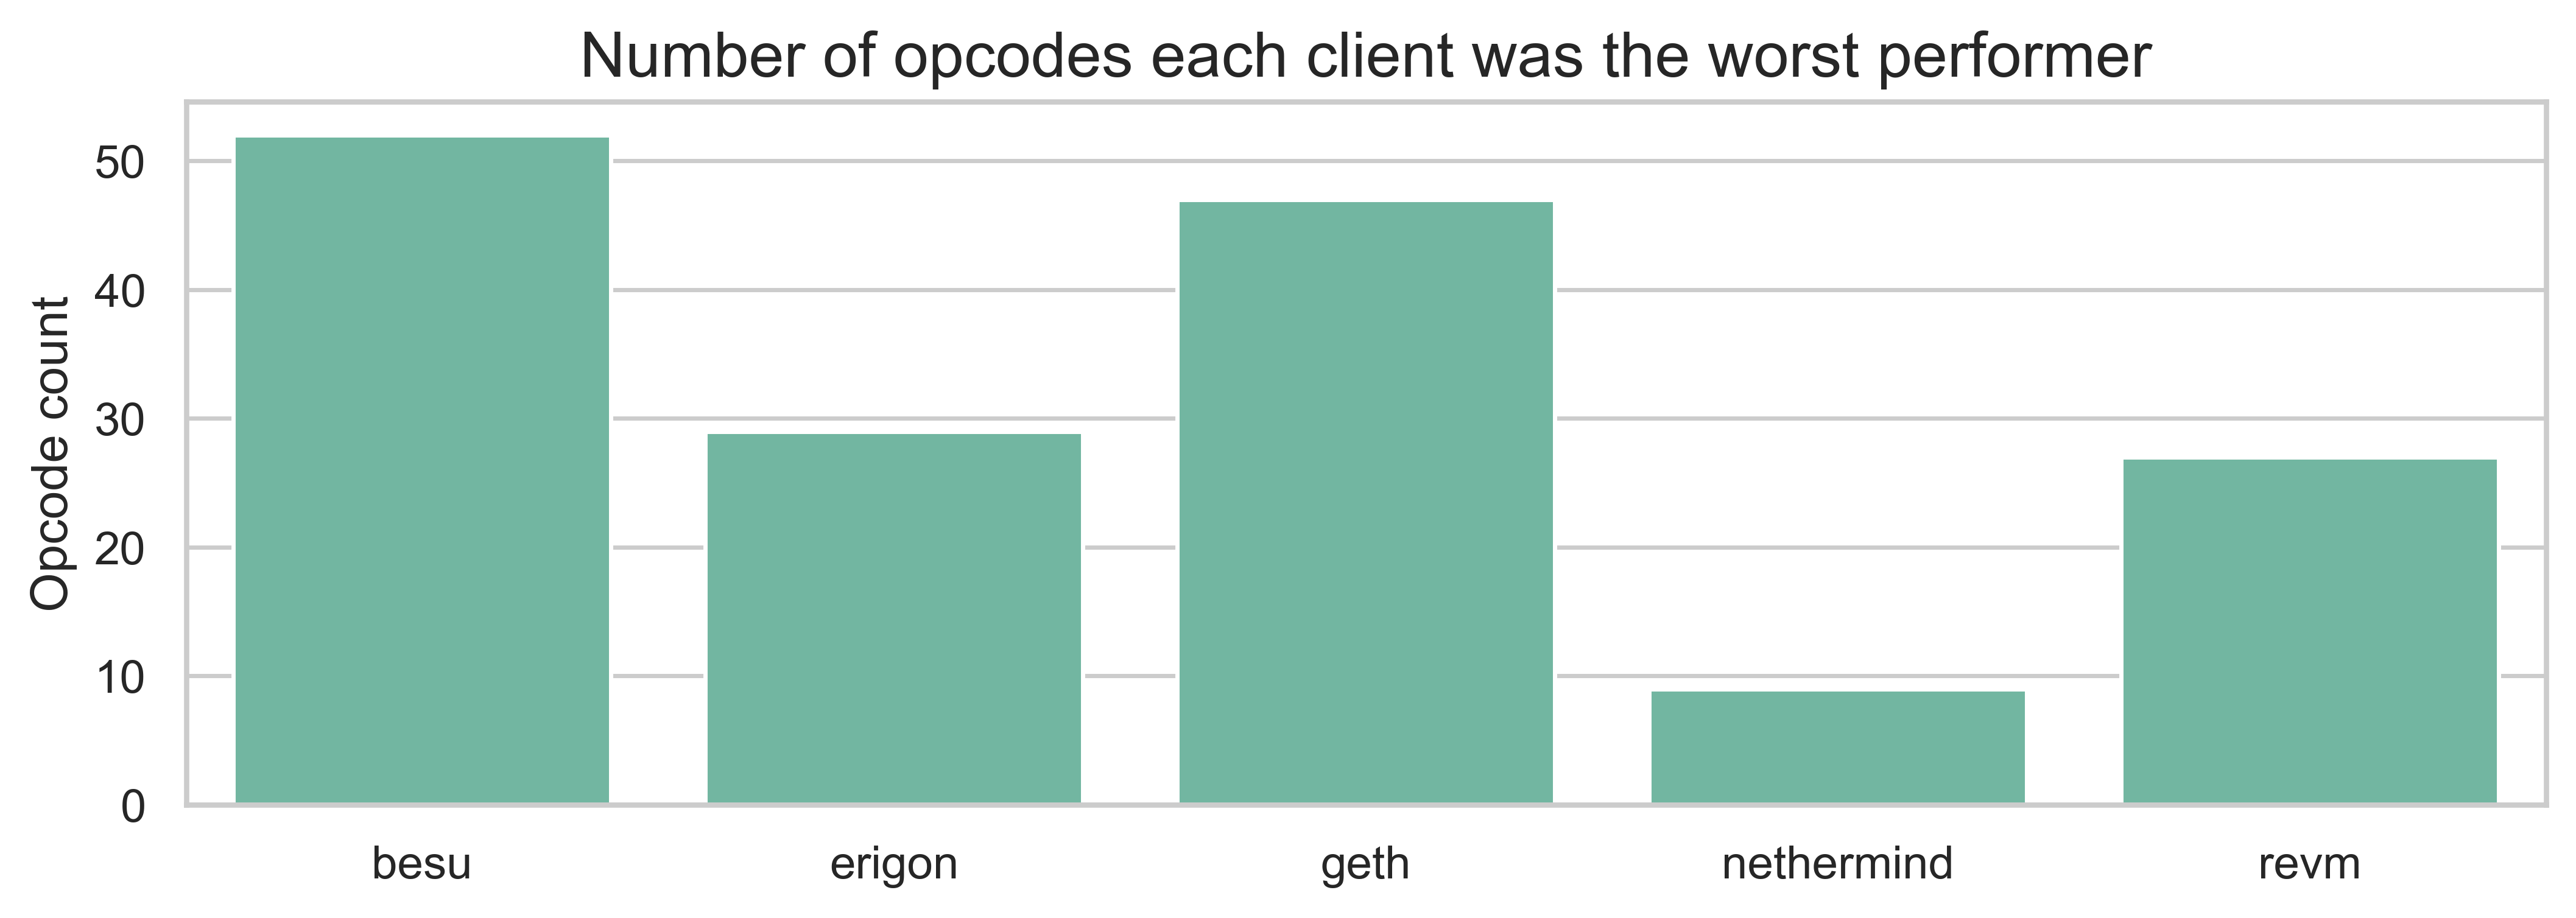

In [18]:
plt.figure(figsize=(10, 3))
sns.countplot(new_gas_df.sort_values("client"), x="client")
plt.title("Number of opcodes each client was the worst performer")
plt.xlabel("")
plt.ylabel("Opcode count")
plt.show()

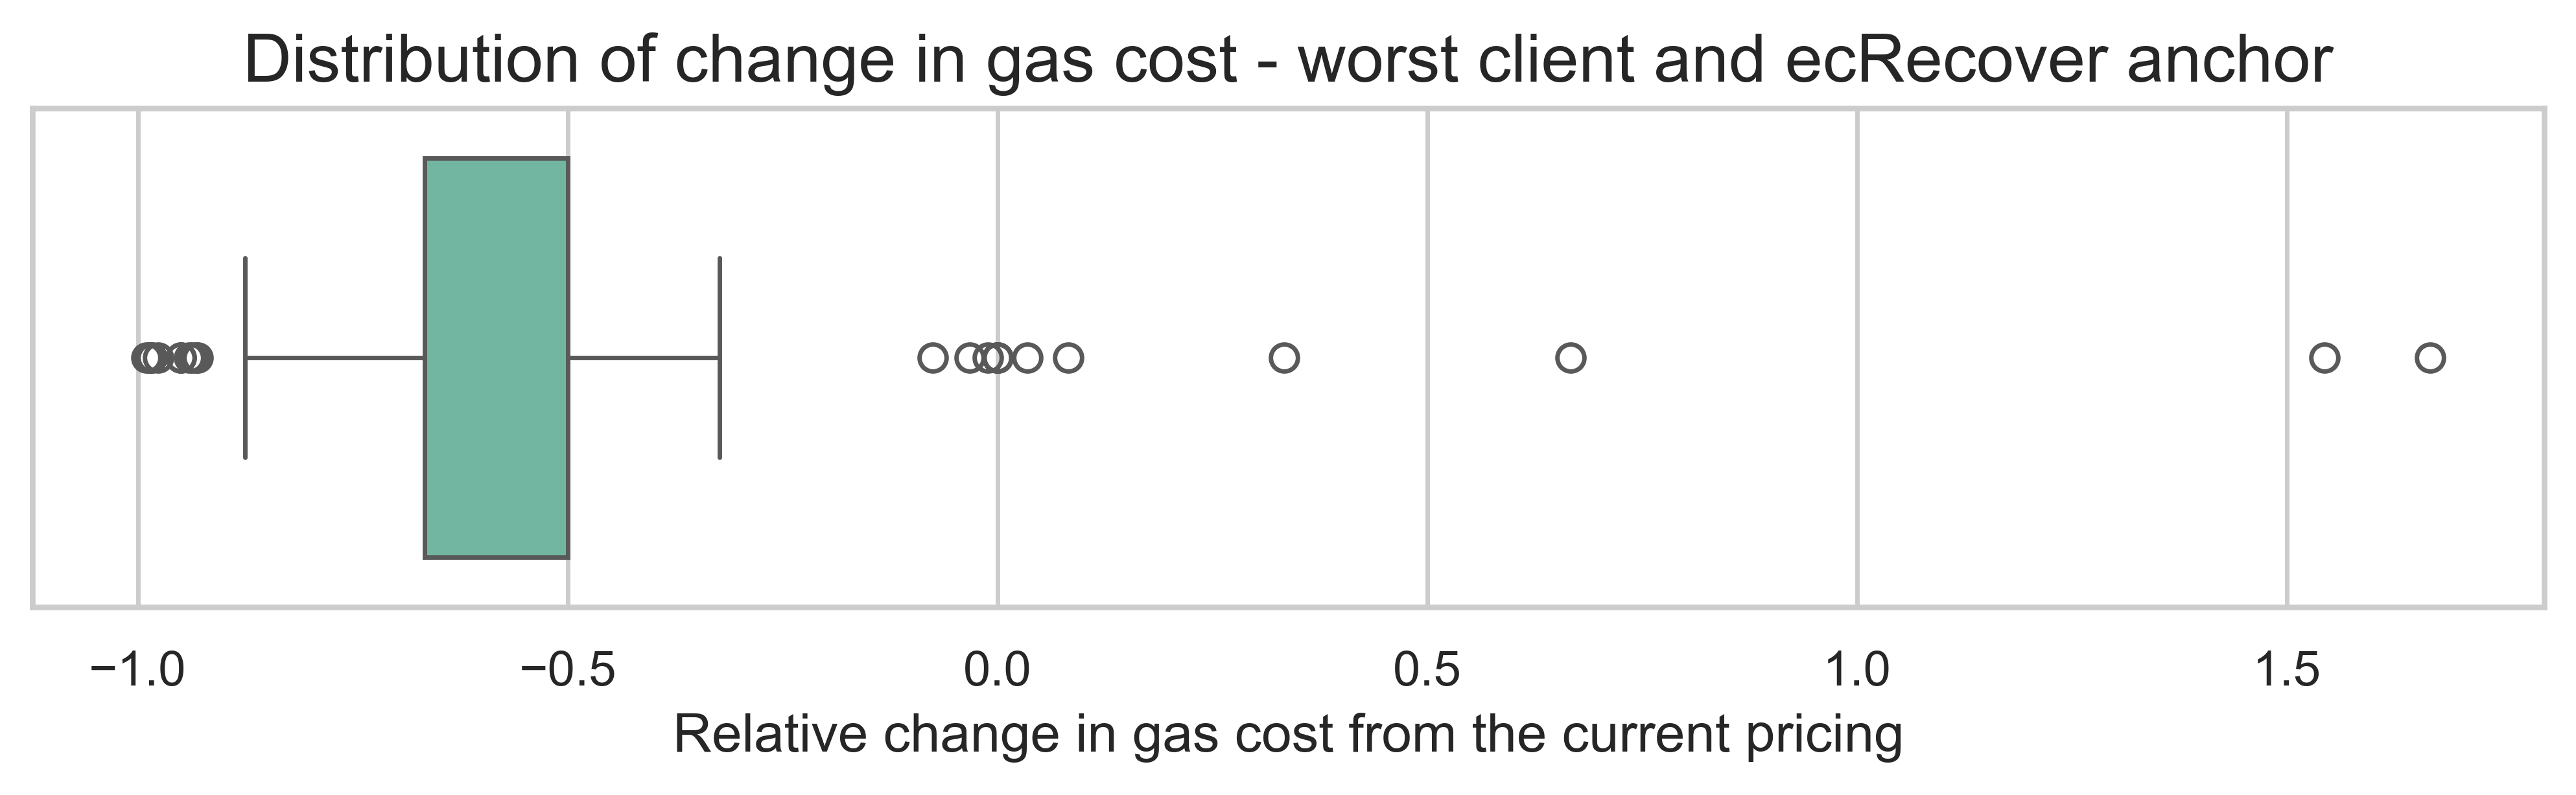

In [19]:
plt.figure(figsize=(10, 2))
sns.boxplot(
    data=new_gas_df,
    x="new_gas_change"
)

plt.title("Distribution of change in gas cost - worst client and ecRecover anchor")
plt.ylabel("")
plt.xlabel("Relative change in gas cost from the current pricing")
plt.show()

In [20]:
new_gas_df[new_gas_df["new_gas_change"]>0]

,opcode,client,param_ns,new_gas,new_gas_rounded,constant_current_gas,alternative_gas,new_gas_change
37,ECADD,erigon,3.642884e+03,635.718518,636,250.000,3239.289545,1.544000
40,ECPAIRING181000,erigon,1.074028e+06,187428.321943,187428,181100.000,173520.539292,0.034942
41,ECPAIRING317000,erigon,1.967311e+06,343314.849139,343315,317100.000,306352.798529,0.082671
59,KECCAK256,revm,2.772638e+02,48.385215,48,36.000,137.303782,0.333333
122,RETURN,erigon,1.889061e+01,3.296593,3,0.000,5.768244,inf
123,RETURNDATACOPY,erigon,2.888288e+01,5.040342,5,3.000,8.912552,0.666667
125,REVERT,besu,3.597691e+01,6.278319,6,0.000,24.965269,inf
133,SHA2-256_ARG1,besu,7.645158e-01,0.133415,1,0.375,0.172574,1.666667


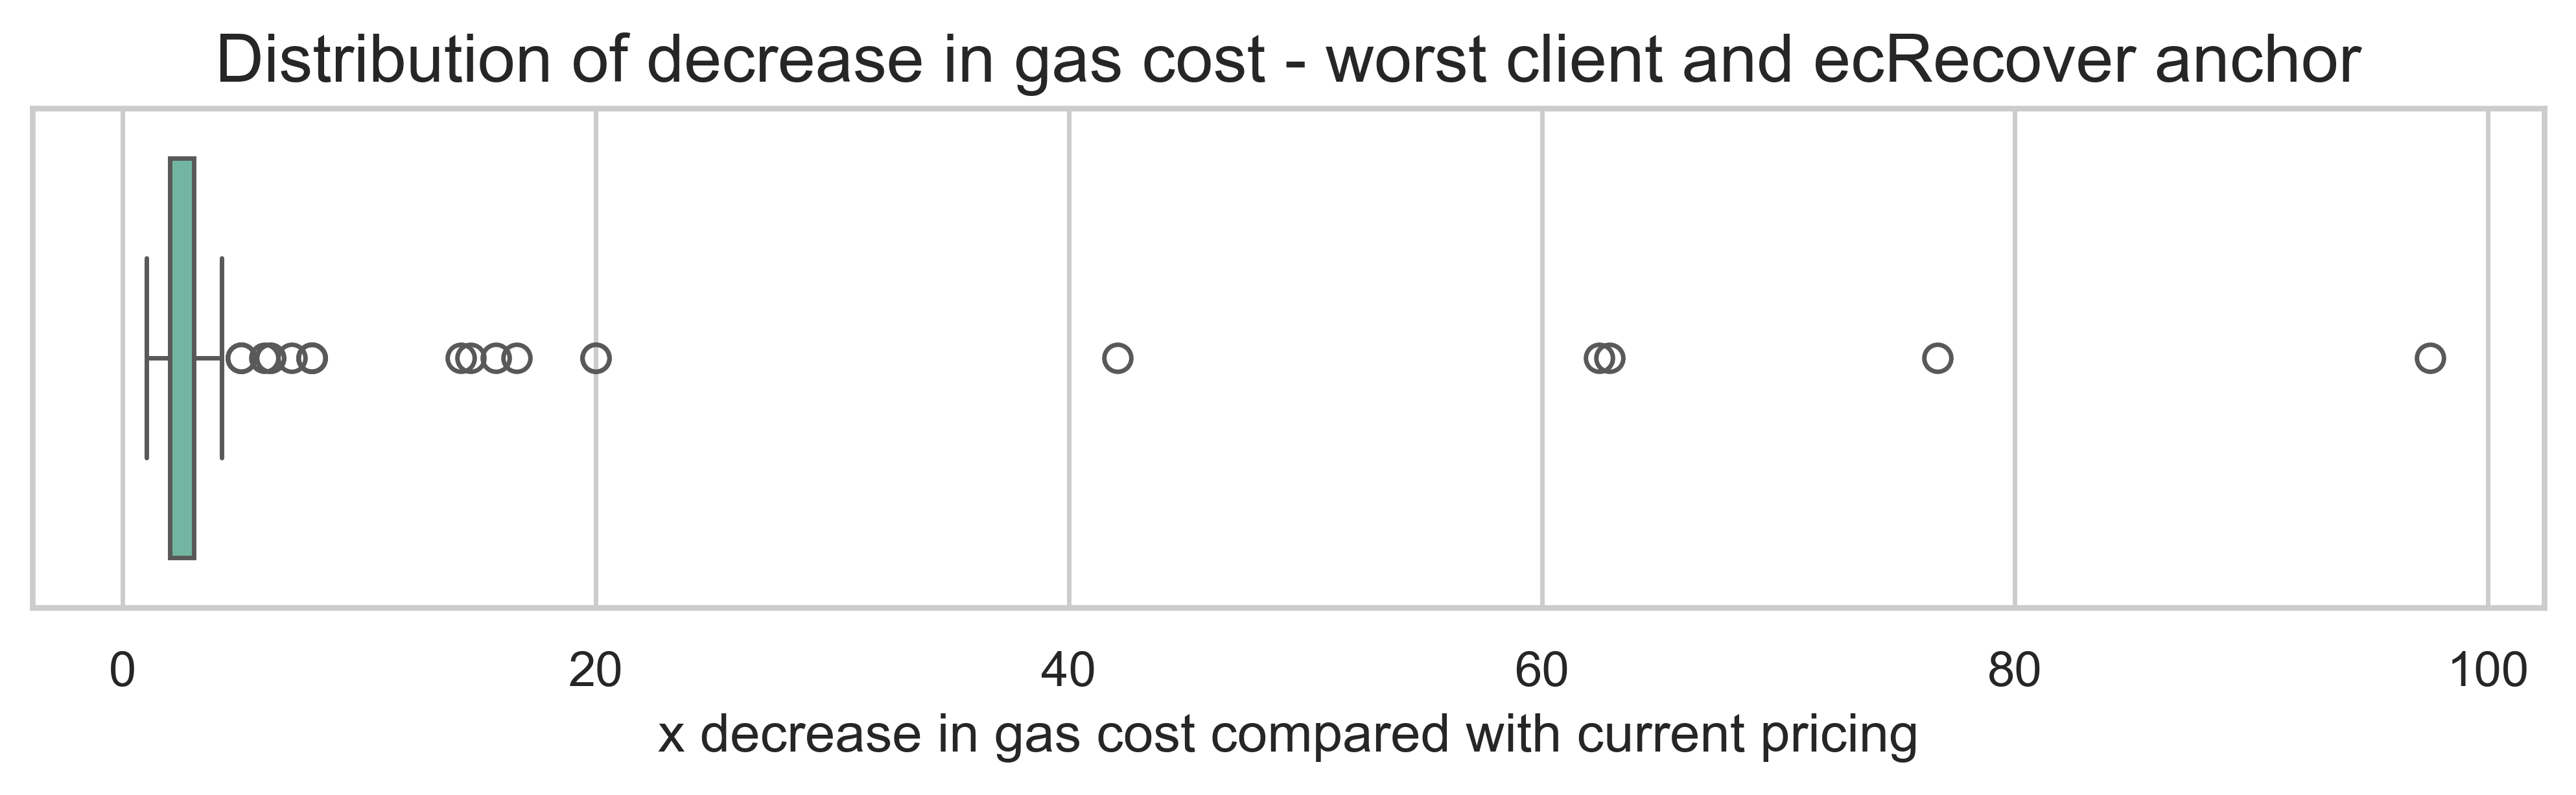

In [21]:
temp = new_gas_df[new_gas_df["new_gas_change"]<0]
temp["new_gas_decrease"] = new_gas_df["constant_current_gas"]/new_gas_df["new_gas_rounded"]

plt.figure(figsize=(10, 2))
sns.boxplot(
    data=temp,
    x="new_gas_decrease"
)
plt.title("Distribution of decrease in gas cost - worst client and ecRecover anchor")
plt.ylabel("")
plt.xlabel("x decrease in gas cost compared with current pricing")
plt.show()

In [22]:
temp[temp["new_gas_decrease"]>5]

,opcode,client,param_ns,new_gas,new_gas_rounded,constant_current_gas,alternative_gas,new_gas_change,new_gas_decrease
16,CREATE,geth,2937.201008,512.569992,513,32020.0,621.921224,-0.983979,62.417154
46,EXP_ARG1,nethermind,45.865094,8.003903,8,50.0,37.837092,-0.840000,6.250000
47,EXTCODECOPY,nethermind,42.937711,7.493046,7,103.0,16.749840,-0.932039,14.714286
48,EXTCODEHASH,erigon,40.075641,6.993587,7,100.0,20.177531,-0.930000,14.285714
49,EXTCODESIZE,erigon,33.874746,5.911471,6,100.0,17.522780,-0.940000,16.666667
56,JUMP,erigon,8.318829,1.451716,1,8.0,3.443185,-0.875000,8.000000
60,KECCAK256_ARG1,revm,1.920549,0.335154,1,6.0,0.626871,-0.833333,6.000000
61,LOG0,geth,84.500630,14.746177,15,631.0,35.124280,-0.976228,42.066667
62,LOG0_ARG1,revm,0.186500,0.032546,1,8.0,0.087711,-0.875000,8.000000
63,LOG1,geth,93.136584,16.253235,16,1006.0,57.799526,-0.984095,62.875000


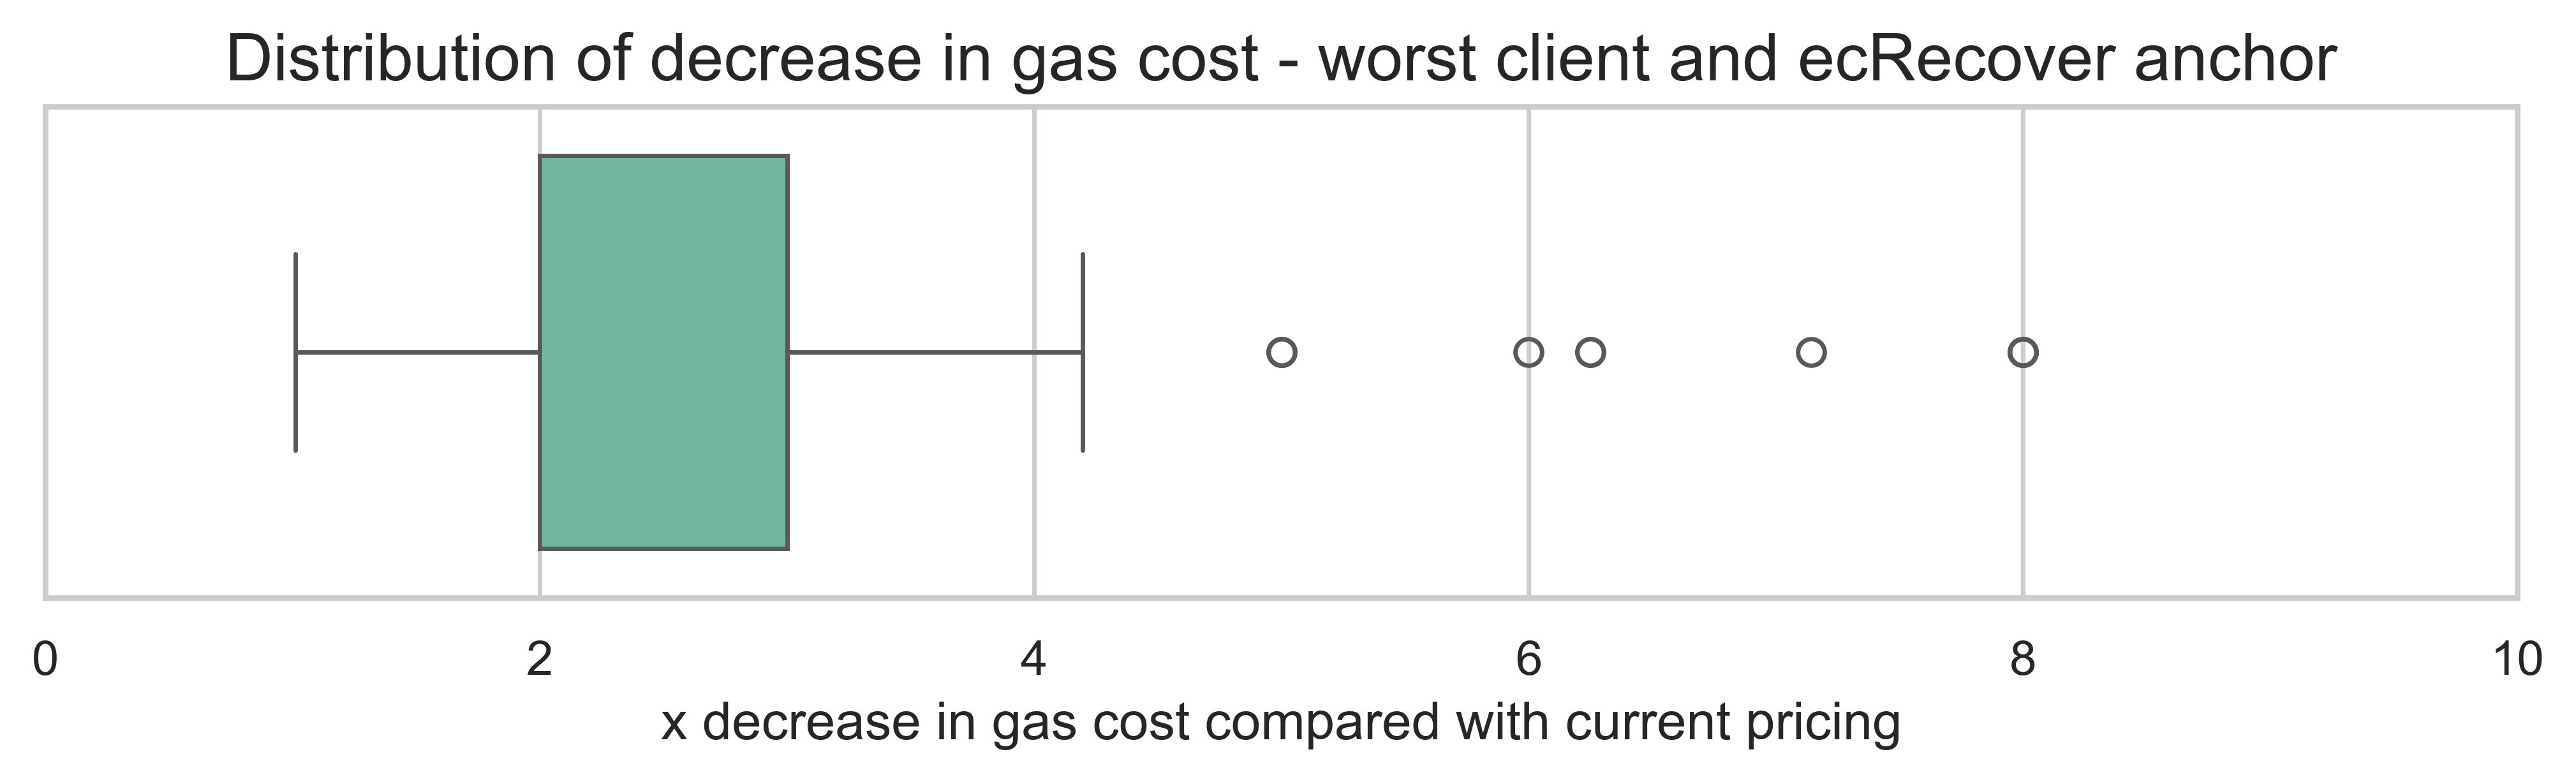

In [23]:
plt.figure(figsize=(10, 2))
sns.boxplot(
    data=temp,
    x="new_gas_decrease"
)
plt.xlim(0,10)
plt.title("Distribution of decrease in gas cost - worst client and ecRecover anchor")
plt.ylabel("")
plt.xlabel("x decrease in gas cost compared with current pricing")
plt.show()

## Setting gas costs by worse client - fastest opcode anchor + deci-gas

In [15]:
worse_df = (
    param_df.drop(columns="param_ns_std")
    .dropna()
    .sort_values("param_ns")
    .groupby("opcode")
    .last()
    .reset_index()
)
worse_df[~worse_df["opcode"].str.contains("ARG")].sort_values("param_ns").head(1)

,opcode,client,param_ns
57,JUMPDEST,geth,1.741227


Translating the execution time of the fastest opcode for the worse client to Mgas/s we get:

In [28]:
fastest_param = worse_df[~worse_df["opcode"].str.contains("ARG")]["param_ns"].min()
print("Fastest opcode execution time:", round(fastest_param, 1), "ns")
print("Fastest opcode derived Mgas/s:", round((1e9*0.1/fastest_param)/1e6))

Fastest opcode execution time: 1.7 ns
Fastest opcode derived Mgas/s: 57


In [29]:
new_gas_df = (
    param_df.drop(columns="param_ns_std")
    .dropna()
    .sort_values("param_ns")
    .groupby("opcode")
    .last()
    .reset_index()
)
# fastest opcode anchor
a = 0.1 / fastest_param
print("Fastest opcode Anchor Multiplier:", round(a, 2))
new_gas_df["new_gas"] = new_gas_df["param_ns"] * a
new_gas_df["new_gas_rounded"] = new_gas_df["new_gas"].round(1)
new_gas_df["new_gas_rounded"] = np.where(
    new_gas_df["new_gas_rounded"] == 0.0, 0.1, new_gas_df["new_gas_rounded"]
)
new_gas_df = new_gas_df.merge(
    df[["opcode", "constant_current_gas", "alternative_gas"]], on="opcode", how="left"
)
new_gas_df["new_gas_change"] = (
    new_gas_df["new_gas_rounded"] - new_gas_df["constant_current_gas"]
) / new_gas_df["constant_current_gas"]

new_gas_df.to_csv(os.path.join(data_dir, "proposed_gas_schedule_fastest_op.csv"), index=False)

Fastest opcode Anchor Multiplier: 0.06


In [30]:
new_gas_df

,opcode,client,param_ns,new_gas,new_gas_rounded,constant_current_gas,alternative_gas,new_gas_change
0,ADD,besu,7.171282,0.411852,0.4,3.0,2.224481,-0.866667
1,ADDMOD,revm,25.502540,1.464630,1.5,8.0,8.116796,-0.812500
2,ADDRESS,geth,7.997121,0.459281,0.5,2.0,5.274908,-0.750000
3,AND,besu,3.857343,0.221530,0.2,3.0,2.461954,-0.933333
4,BLAKE2F,besu,258.113508,14.823654,14.8,112.0,172.546564,-0.867857
...,...,...,...,...,...,...,...,...
159,TLOAD_EXT,geth,28.841101,1.656366,1.7,100.0,18.694864,-0.983000
160,TSTORE,geth,83.060644,4.770236,4.8,100.0,25.225150,-0.952000
161,TSTORE0,geth,115.165377,6.614035,6.6,100.0,39.368778,-0.934000
162,TSTORE_EXT,geth,92.914882,5.336172,5.3,100.0,43.718183,-0.947000


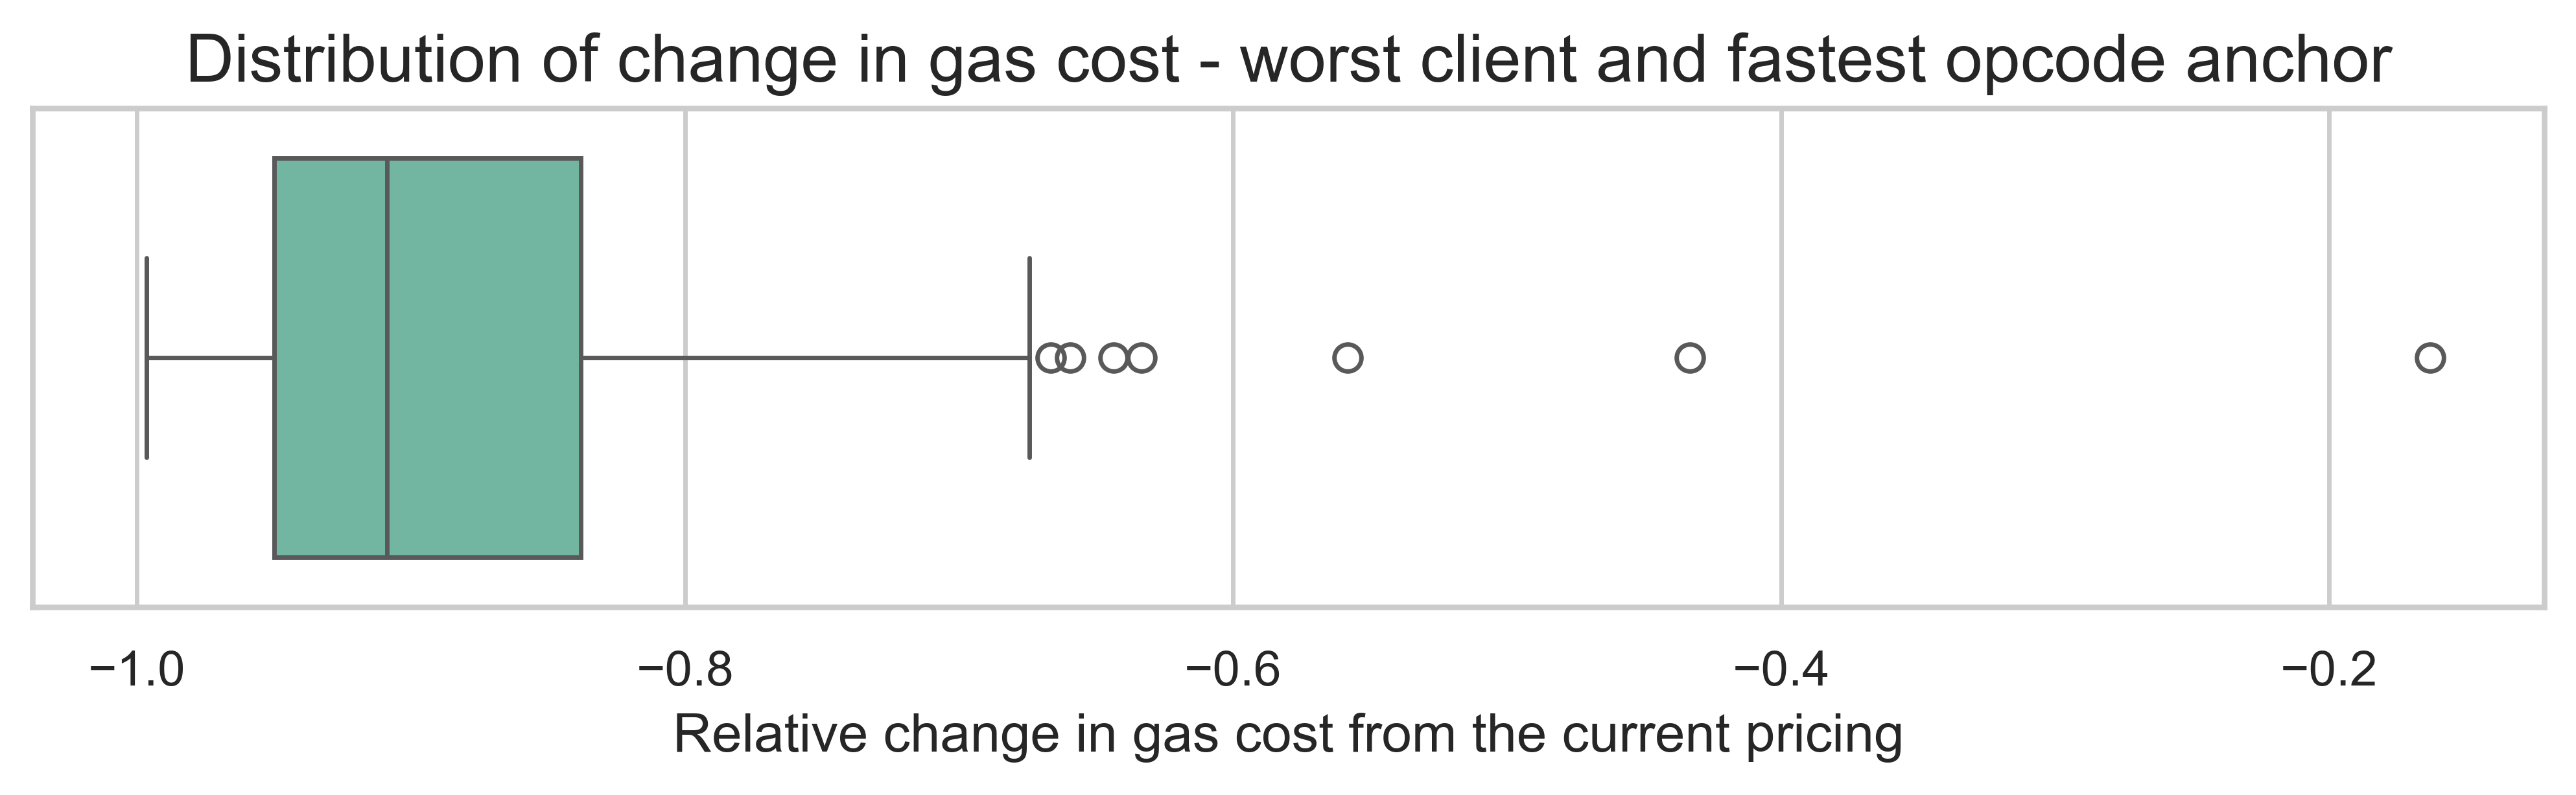

In [31]:
plt.figure(figsize=(10, 2))
sns.boxplot(
    data=new_gas_df,
    x="new_gas_change"
)

plt.title("Distribution of change in gas cost - worst client and fastest opcode anchor")
plt.ylabel("")
plt.xlabel("Relative change in gas cost from the current pricing")
plt.show()

In [32]:
new_gas_df[new_gas_df["new_gas_change"]>0]

,opcode,client,param_ns,new_gas,new_gas_rounded,constant_current_gas,alternative_gas,new_gas_change
122,RETURN,erigon,18.890606,1.084902,1.1,0.0,5.768244,inf
125,REVERT,besu,35.976914,2.066181,2.1,0.0,24.965269,inf


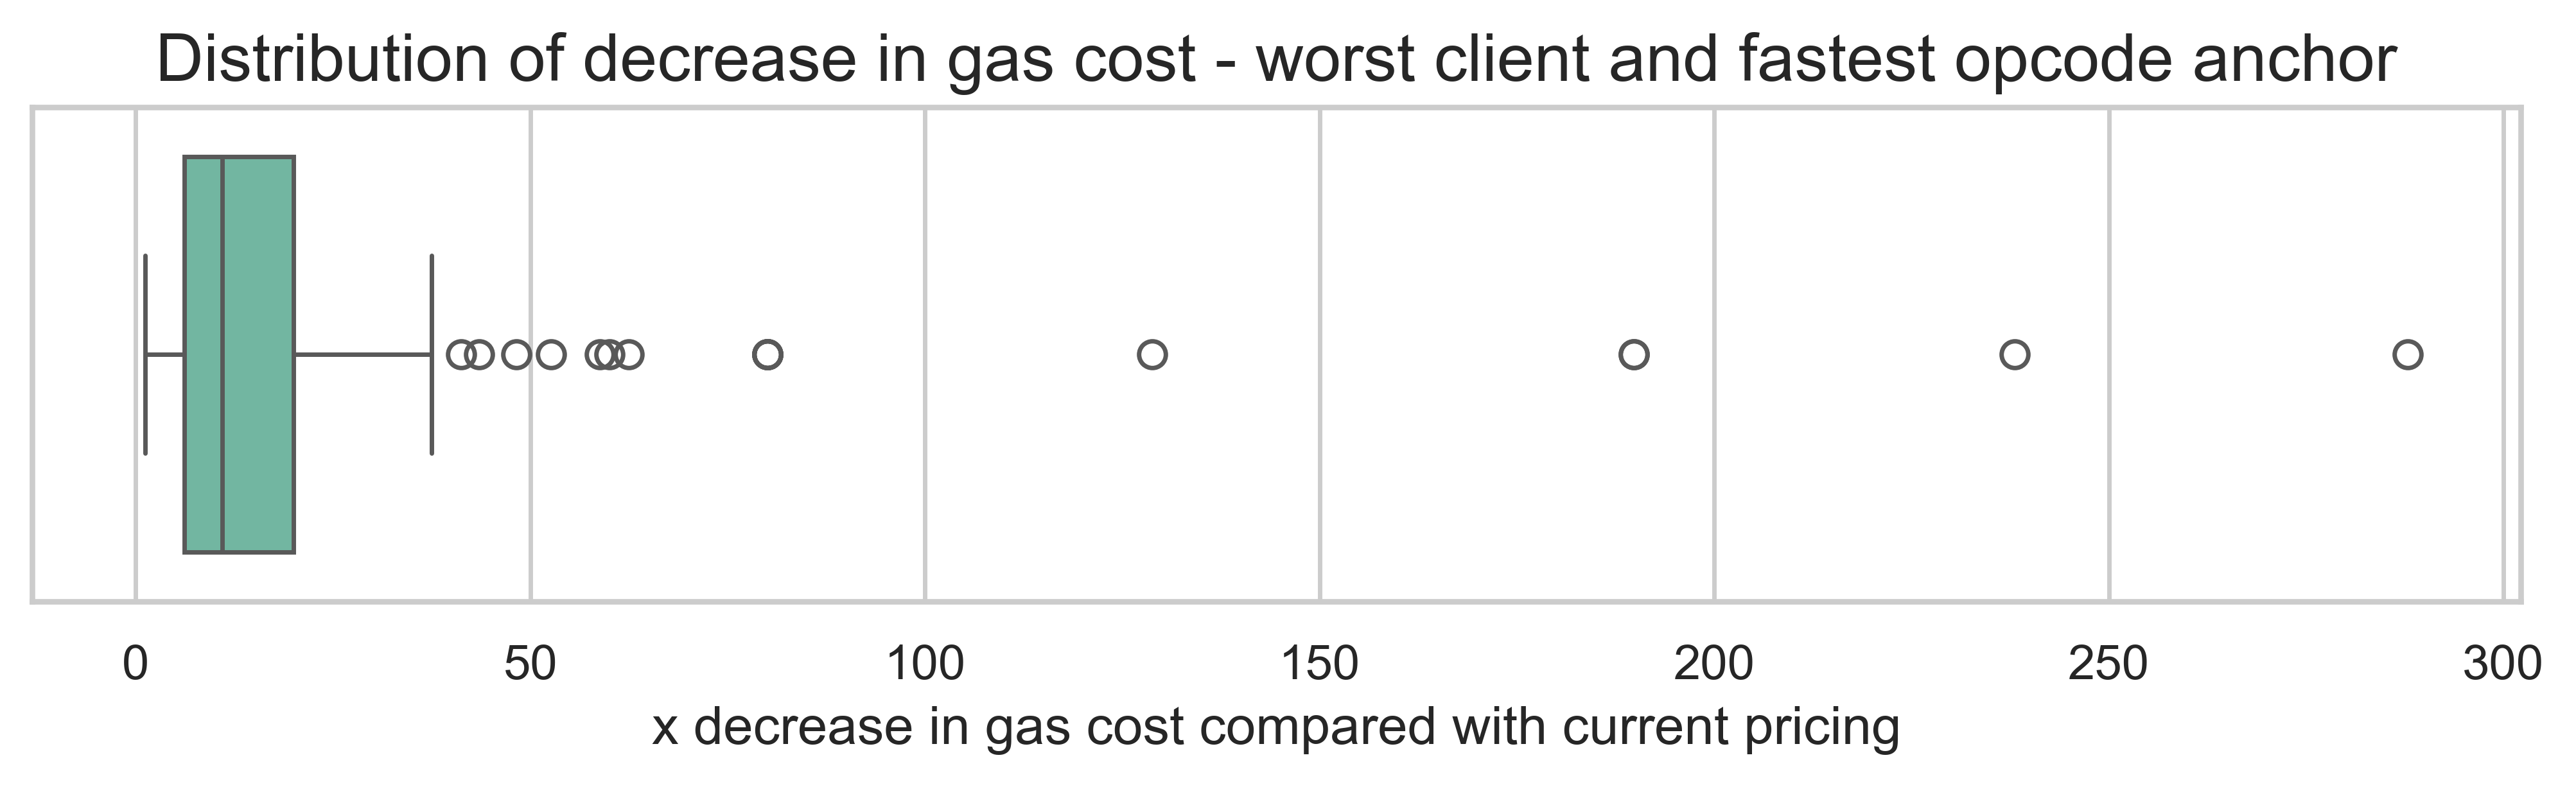

In [33]:
temp = new_gas_df[new_gas_df["new_gas_change"]<0]
temp["new_gas_decrease"] = new_gas_df["constant_current_gas"]/new_gas_df["new_gas_rounded"]

plt.figure(figsize=(10, 2))
sns.boxplot(
    data=temp,
    x="new_gas_decrease"
)
plt.title("Distribution of decrease in gas cost - worst client and fastest opcode anchor")
plt.ylabel("")
plt.xlabel("x decrease in gas cost compared with current pricing")
plt.show()

In [34]:
temp[temp["new_gas_decrease"]>5]

,opcode,client,param_ns,new_gas,new_gas_rounded,constant_current_gas,alternative_gas,new_gas_change,new_gas_decrease
0,ADD,besu,7.171282,0.411852,0.4,3.0,2.224481,-0.866667,7.500000
1,ADDMOD,revm,25.502540,1.464630,1.5,8.0,8.116796,-0.812500,5.333333
3,AND,besu,3.857343,0.221530,0.2,3.0,2.461954,-0.933333,15.000000
4,BLAKE2F,besu,258.113508,14.823654,14.8,112.0,172.546564,-0.867857,7.567568
5,BYTE,geth,3.267950,0.187681,0.2,3.0,2.820659,-0.933333,15.000000
...,...,...,...,...,...,...,...,...,...
159,TLOAD_EXT,geth,28.841101,1.656366,1.7,100.0,18.694864,-0.983000,58.823529
160,TSTORE,geth,83.060644,4.770236,4.8,100.0,25.225150,-0.952000,20.833333
161,TSTORE0,geth,115.165377,6.614035,6.6,100.0,39.368778,-0.934000,15.151515
162,TSTORE_EXT,geth,92.914882,5.336172,5.3,100.0,43.718183,-0.947000,18.867925


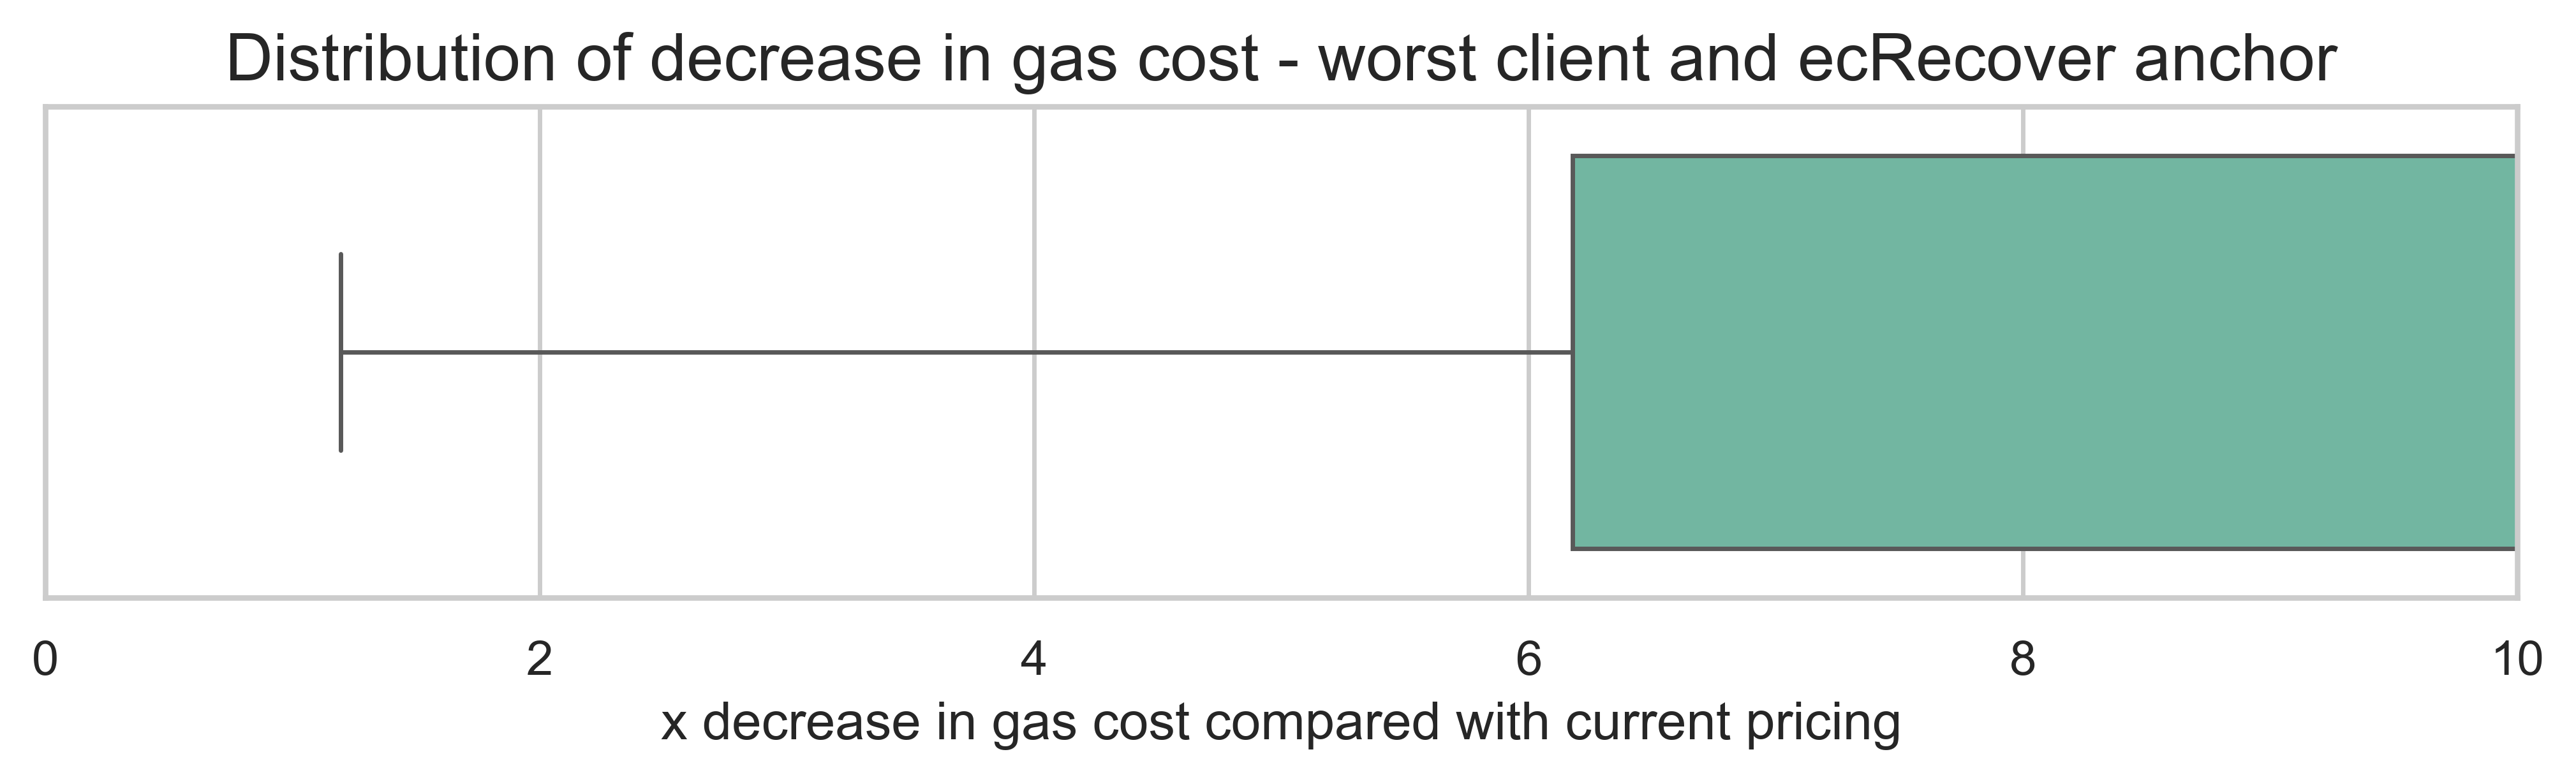

In [35]:
plt.figure(figsize=(10, 2))
sns.boxplot(
    data=temp,
    x="new_gas_decrease"
)
plt.xlim(0,10)
plt.title("Distribution of decrease in gas cost - worst client and ecRecover anchor")
plt.ylabel("")
plt.xlabel("x decrease in gas cost compared with current pricing")
plt.show()